In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./data/clean_henrys.csv', index_col=0)

In [3]:
df.head()

,inchikey,species_id,iupac,htype,mindhr,subcat_id,value,canonical_smiles,complexity,molecular_weight,tpsa,h_bond_acceptor_count,h_bond_donor_count,covalent_unit_count
0,AAPLIUHOKVUFCC-UHFFFAOYSA-N,4565,trimethylsilanol,M,NaN,55,0.070000,C[Si](C)(C)O,28.4,90.20,20.2,1,1,1
1,ABVVEAHYODGCLZ-UHFFFAOYSA-N,1654,1-tridecanamine,M,NaN,30,0.090000,CCCCCCCCCCCCCN,91.2,199.38,26.0,1,1,1
2,AFABGHUZZDYHJO-UHFFFAOYSA-N,87,2-methylpentane,M,960.0,11,0.000013,CCCC(C)C,21.2,86.18,0.0,0,0,1
3,AFYPFACVUDMOHA-UHFFFAOYSA-N,3670,chlorotrifluoromethane,M,2050.0,46,0.000009,C(F)(F)(F)Cl,28.4,104.46,0.0,3,0,1
4,AGDYNDJUZRMYRG-UHFFFAOYSA-N,2220,1-hexyl nitrate,M,6700.0,35,0.007600,CCCCCCO[N+](=O)[O-],89.5,147.17,55.0,3,0,1


In [4]:
# Let's remove the columns we don't need
X = df.drop(columns=['inchikey',
                     'species_id', 
                     'iupac', 
                     'htype',
                     'mindhr',
                     'canonical_smiles',
                     'subcat_id'
                    ])

# Set up predictive values
y = X['value']
X = X.drop(columns='value')

In [5]:
y_log = np.log10(y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2)

# Now that the data is set up, let's throw some basic regression at it.

In [15]:
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor()

clf.fit(X_train, y_train)

mean_squared_error(y_test, clf.predict(X_test))

2.3250736074260168

So when looking at MSE, we get a value that is notably worse than the estimations.

In [25]:
from sklearn import tree

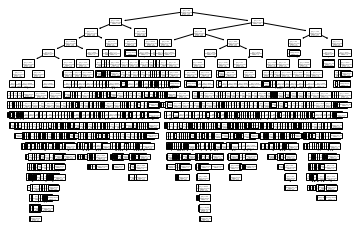

In [28]:
tree.plot_tree(clf)
plt.show()

So this decision tree is very complex. We should see if we can restrict the tree to be more generalizable.

In [16]:
clf = DecisionTreeRegressor(max_depth=6, min_samples_split=10)
clf.fit(X_train, y_train)
mean_squared_error(y_test, clf.predict(X_test))

1.7653877032961847

In [17]:
tree.plot_tree(clf)
plt.show()

NameError: name 'tree' is not defined

So, looks like we aren't going to get good performance out of a Decision Tree, as to be expected.

In [18]:
# Show that the distribution doesn't change
df_full = pd.read_csv('./data/henrys-law.csv')

df_full.head()

,id,hominus,mindhr,htype,species_id,literature_id,id.1,iupac,formula,trivial,casrn,inchikey,subcat_id
0,1,1.2*10**-5,1700.0,L,1,729.0,1,oxygen,O<sub>2</sub>,NaN,7782-44-7,MYMOFIZGZYHOMD-UHFFFAOYSA-N,1
1,2,1.3*10**-5,1500.0,L,1,603.0,1,oxygen,O<sub>2</sub>,NaN,7782-44-7,MYMOFIZGZYHOMD-UHFFFAOYSA-N,1
2,3,1.3*10**-5,1500.0,L,1,602.0,1,oxygen,O<sub>2</sub>,NaN,7782-44-7,MYMOFIZGZYHOMD-UHFFFAOYSA-N,1
3,4,1.3*10**-5,1400.0,L,1,239.0,1,oxygen,O<sub>2</sub>,NaN,7782-44-7,MYMOFIZGZYHOMD-UHFFFAOYSA-N,1
4,5,1.3*10**-5,1500.0,L,1,57.0,1,oxygen,O<sub>2</sub>,NaN,7782-44-7,MYMOFIZGZYHOMD-UHFFFAOYSA-N,1


In [19]:
df_full.drop(df_full[df_full['hominus'].isna()].index, inplace=True)
df_full['value'] = [eval(v) for v in df_full['hominus']]
types_of_vals = np.log10(pd.pivot_table(df_full, values='value', index='species_id', columns='htype'))

In [20]:
full_values = types_of_vals.reset_index()['M']

In [49]:
full_values

0      -4.894490
1      -3.929962
2            NaN
3      -5.102373
4            NaN
          ...   
4600         NaN
4601         NaN
4602         NaN
4603         NaN
4604   -4.886057
Name: M, Length: 4605, dtype: float64

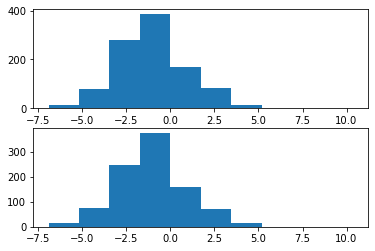

In [21]:
plt.subplot(2,1,1)
plt.hist(full_values)
plt.subplot(2,1,2)
plt.hist(np.log10(df['value']))
plt.show()

As shown above, the distributions look fairly similar (that is, there are no values in the tails that we are omitting from our analysis). Thus, it looks like our evaluation of the Decision Tree is correct.

This proves that the physical characteristics of the molecules, regardless of the chemical structure, can be used to predict Henry's law as well as estimation values referenced in the literature.

In [22]:
# Let's see how well a random forest does
clf = RandomForestRegressor()
clf.fit(X_train, y_train)

mean_squared_error(y_test, clf.predict(X_test))

1.281777080298362

In [23]:
# How well does this perform on the training set?
mean_squared_error(y_train, clf.predict(X_train))

0.1778816451135007

So, even with a random forest thrown at the problem, we still can't quite get performance that beats the estimated values. This makes sense, as we should expect the traditional estimation methods work better.

I think the dataset size is going to be a cause for concern.

Mol2Vec seems like its going to work better!

In [24]:
from mol2vec import features

ModuleNotFoundError: No module named 'rdkit'

In [25]:
!conda list -n my-rdkit-env

# packages in environment at /opt/anaconda3/envs/my-rdkit-env:
#
# Name                    Version                   Build  Channel
appnope                   0.1.2           py39hecd8cb5_1001  
argon2-cffi               21.3.0             pyhd3eb1b0_0  
argon2-cffi-bindings      21.2.0           py39hca72f7f_0  
asttokens                 2.0.5              pyhd3eb1b0_0  
attrs                     21.4.0             pyhd3eb1b0_0  
backcall                  0.2.0              pyhd3eb1b0_0  
blas                      1.0                         mkl  
bleach                    4.1.0              pyhd3eb1b0_0  
boost                     1.74.0           py39ha1f3e3e_5    conda-forge
boost-cpp                 1.74.0               hdbf7018_7    conda-forge
brotli                    1.0.9                h0d85af4_6    conda-forge
brotli-bin                1.0.9                h0d85af4_6    conda-forge
bzip2                     1.0.8                h0d85af4_4    conda-forge
ca-certificates      